In [1]:
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import copy
from multiprocessing.pool import Pool
import re
positive_file = 'data/rt-polarity.pos'
negative_file = 'data/rt-polarity.neg'
data_root = 'data/stanfordSentimentTreebank/'
glove_pattern = 'data/glove.6B.<size>d.txt'
glove_size = 300

In [2]:
glove_dict = None
def get_glove(size = 50):
    global glove_dict
    if glove_dict is None or len(list(glove_dict.values())[0]) != size:
        file = re.sub('<size>', str(size), glove_pattern)
        glove = pd.read_csv(file, sep = " ", header = None, index_col = 0, quoting = 3)
        glove_dict = {key: val.values for key, val in glove.T.items()}
    return glove_dict

def preprocess_sentence(line):
    line = re.sub(r'[^\x00-\x7F]+', '', line.strip())
    return line.strip().lower()

def preprocess_for_labels(line):
    line = preprocess_sentence(line)
    line = re.sub('\W+', '', line.strip())
    return line
    
def get_labelset(file):
    with open(file, "rt", encoding="utf-8") as f:
        sentences = set([preprocess_for_labels(line) for line in f.readlines()])
    return sentences

In [3]:
positive_labelset = get_labelset(positive_file)
negative_labelset = get_labelset(negative_file)

In [4]:
data_split_dict = {}
data_split_map = {'1': 'train', '2': 'test', '3':'val'}
with open(data_root + 'datasetSplit.txt', 'r') as f:
    for line in f.readlines():
        [index, set_code] = line.strip().split(',')
        try:
            index = int(index)
        except:
            continue
        if set_code not in data_split_map:
            print(index, set_code)
        data_split_dict[index] = data_split_map.get(set_code, 'val')

In [13]:
def check_sentiment(sentence):
    s = preprocess_for_labels(sentence)
    for y, labelset in enumerate([negative_labelset, positive_labelset]):
        for entry in labelset:
            if s in labelset:
                return y
    return -1

sentences = {}
word2ind = {}
ttws = tf.keras.preprocessing.text.text_to_word_sequence
n_skipped = 0
idx = 0
with open(data_root + 'datasetSentences.txt') as data:
    lines = data.readlines()
    for line in lines:
        index = re.search('^\d+', line)
        if index is None:
            continue
        index = int(index.group())
        if index not in data_split_dict:
            print(index, line)
        entry = {'split_set': data_split_dict.get(index, 'val')}
        line = preprocess_sentence(line)
        line = re.sub(r'^\d+\s+', '', line)
        sentiment = check_sentiment(line)
        if sentiment >= 0:
            entry['y'] = sentiment
        else:
            n_skipped += 1
            continue
        sentences[line] = entry
        tokens = ttws(line)
        for token in tokens:
            if token not in word2ind:
                word2ind[token] = idx
                idx = idx + 1
            
print(n_skipped, ' skipped')
print(len(sentences), ' kept')

2775  skipped
9077  kept


In [14]:
data_splits = {title: {'x':[], 'y':[]} for title in ['train', 'test', 'val']}
for line, entry in sentences.items():
    which = entry['split_set']
    tokenized = [int(word2ind[token]) for token in ttws(line)]
    (data_splits[which]['x']).append(tokenized)
    (data_splits[which]['y']).append(int(entry['y']))

In [15]:
def get_dataset(label, sequence_len):
    vals = data_splits[label]
    x = [np.array(vx) for vx in vals['x']]
    x = tf.keras.preprocessing.sequence.pad_sequences(x,
                                                      padding = 'post',
                                                      maxlen = sequence_len)
    y = np.array(vals['y'])
    return x, y

In [95]:
def get_embedding_matrix(glove_size):
    glove = get_glove(glove_size)
    glove_words = set(glove.keys())
    default_vector = np.mean(list(glove.values()), axis = 0)
    embedding_matrix = np.empty((len(word2ind), default_vector.shape[0]))
    for word, position in word2ind.items():
        embedding_matrix[position,:] = glove.get(word, default_vector)
    return embedding_matrix


In [109]:
class RnnModel(tf.keras.Model):
    
    def __init__(self, 
                 hidden_states = None, 
                 embedding = 50, 
                 train_embeddings = False):
        super(RnnModel, self).__init__()
        self.init_layer_type()
        hidden_states = [8] if hidden_states is None else copy.copy(hidden_states)
        embedding_matrix = get_embedding_matrix(glove_size)
        self.embedding = tf.keras.layers.Embedding(
            embedding_matrix.shape[0], 
            embedding_matrix.shape[1], 
            embeddings_initializer=tf.keras.initializers.Constant(embedding_matrix),
            trainable = train_embeddings,
            mask_zero = True)
        self.final_rnn = self.layer_type(hidden_states.pop())
        self.hidden_layers = [self.layer_type(n, return_sequences = True) for n in hidden_states]
        self.logistic = tf.keras.layers.Dense(1, activation = 'sigmoid')

    def init_layer_type(self):
        self.layer_type = tf.keras.layers.SimpleRNN
        
    def call(self, inputs, training = False):
        x = self.embedding(inputs)
        mask = self.embedding.compute_mask(inputs)
        for layer in self.hidden_layers:
            layer(x, mask = mask)
            mask = None
        return self.logistic(self.final_rnn(x, mask = mask))

class LstmModel(RnnModel):
    def init_layer_type(self):
        self.layer_type = tf.keras.layers.LSTM

class GruModel(RnnModel):
    def init_layer_type(self):
        self.layer_type = tf.keras.layers.GRU
            
def compile_model(model = RnnModel, lr = .01, model_args = {}, metrics = ['BinaryAccuracy']):
    net = model(**model_args)
    optimizer = tf.keras.optimizers.Adam(learning_rate = lr)
    net.compile(loss='binary_crossentropy', optimizer=optimizer, metrics = metrics)
    return net

def run_model(model_type = RnnModel, verbose = 2, epochs = 100, batch_size = 500, 
              sequence_len = 25, learning_rate = .001, model_args = {}):
    (xtrain, ytrain)= get_dataset('train', sequence_len)
    (xval, yval) = get_dataset('val', sequence_len)
    model = compile_model(model_type, learning_rate, model_args)
    es_callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', 
                                                   patience=2, 
                                                   restore_best_weights = True)
    train_history = model.fit(xtrain, ytrain, 
                              callbacks = [es_callback],
                              validation_data = (xval, yval),
                              batch_size = batch_size,
                              epochs = epochs,
                              verbose = verbose)
    return train_history

In [116]:
vanilla_hists = [run_model()]

Train on 6530 samples, validate on 845 samples
Epoch 1/100
6530/6530 - 8s - loss: 0.7359 - binary_accuracy: 0.5110 - val_loss: 0.6958 - val_binary_accuracy: 0.5396
Epoch 2/100
6530/6530 - 0s - loss: 0.6986 - binary_accuracy: 0.5511 - val_loss: 0.6800 - val_binary_accuracy: 0.5645
Epoch 3/100
6530/6530 - 0s - loss: 0.6786 - binary_accuracy: 0.5781 - val_loss: 0.6676 - val_binary_accuracy: 0.6012
Epoch 4/100
6530/6530 - 0s - loss: 0.6648 - binary_accuracy: 0.5992 - val_loss: 0.6553 - val_binary_accuracy: 0.6272
Epoch 5/100
6530/6530 - 0s - loss: 0.6521 - binary_accuracy: 0.6168 - val_loss: 0.6442 - val_binary_accuracy: 0.6272
Epoch 6/100
6530/6530 - 0s - loss: 0.6400 - binary_accuracy: 0.6328 - val_loss: 0.6317 - val_binary_accuracy: 0.6391
Epoch 7/100
6530/6530 - 0s - loss: 0.6266 - binary_accuracy: 0.6522 - val_loss: 0.6163 - val_binary_accuracy: 0.6627
Epoch 8/100
6530/6530 - 0s - loss: 0.6103 - binary_accuracy: 0.6767 - val_loss: 0.5980 - val_binary_accuracy: 0.6781
Epoch 9/100
6530/

In [117]:
vanilla_lstm_hist = run_model(LstmModel)
vanilla_hists.append(vanilla_lstm_hist)

Train on 6530 samples, validate on 845 samples
Epoch 1/100
6530/6530 - 9s - loss: 0.6981 - binary_accuracy: 0.5074 - val_loss: 0.6834 - val_binary_accuracy: 0.5657
Epoch 2/100
6530/6530 - 0s - loss: 0.6733 - binary_accuracy: 0.6063 - val_loss: 0.6567 - val_binary_accuracy: 0.6414
Epoch 3/100
6530/6530 - 1s - loss: 0.6466 - binary_accuracy: 0.6560 - val_loss: 0.6131 - val_binary_accuracy: 0.7183
Epoch 4/100
6530/6530 - 0s - loss: 0.6043 - binary_accuracy: 0.7029 - val_loss: 0.5487 - val_binary_accuracy: 0.7527
Epoch 5/100
6530/6530 - 0s - loss: 0.5516 - binary_accuracy: 0.7314 - val_loss: 0.5119 - val_binary_accuracy: 0.7633
Epoch 6/100
6530/6530 - 0s - loss: 0.5236 - binary_accuracy: 0.7472 - val_loss: 0.5015 - val_binary_accuracy: 0.7680
Epoch 7/100
6530/6530 - 0s - loss: 0.5035 - binary_accuracy: 0.7639 - val_loss: 0.4967 - val_binary_accuracy: 0.7609
Epoch 8/100
6530/6530 - 0s - loss: 0.4911 - binary_accuracy: 0.7714 - val_loss: 0.4849 - val_binary_accuracy: 0.7787
Epoch 9/100
6530/

In [118]:
vanilla_gru_hist = run_model(GruModel)
vanilla_hists.append(vanilla_gru_hist)

Train on 6530 samples, validate on 845 samples
Epoch 1/100
6530/6530 - 9s - loss: 0.6958 - binary_accuracy: 0.5250 - val_loss: 0.6725 - val_binary_accuracy: 0.5882
Epoch 2/100
6530/6530 - 0s - loss: 0.6673 - binary_accuracy: 0.5975 - val_loss: 0.6498 - val_binary_accuracy: 0.6355
Epoch 3/100
6530/6530 - 0s - loss: 0.6470 - binary_accuracy: 0.6358 - val_loss: 0.6314 - val_binary_accuracy: 0.6639
Epoch 4/100
6530/6530 - 0s - loss: 0.6297 - binary_accuracy: 0.6588 - val_loss: 0.6127 - val_binary_accuracy: 0.6852
Epoch 5/100
6530/6530 - 0s - loss: 0.6115 - binary_accuracy: 0.6778 - val_loss: 0.5915 - val_binary_accuracy: 0.7089
Epoch 6/100
6530/6530 - 0s - loss: 0.5908 - binary_accuracy: 0.6943 - val_loss: 0.5604 - val_binary_accuracy: 0.7373
Epoch 7/100
6530/6530 - 0s - loss: 0.5620 - binary_accuracy: 0.7187 - val_loss: 0.5214 - val_binary_accuracy: 0.7586
Epoch 8/100
6530/6530 - 0s - loss: 0.5282 - binary_accuracy: 0.7427 - val_loss: 0.4881 - val_binary_accuracy: 0.7692
Epoch 9/100
6530/

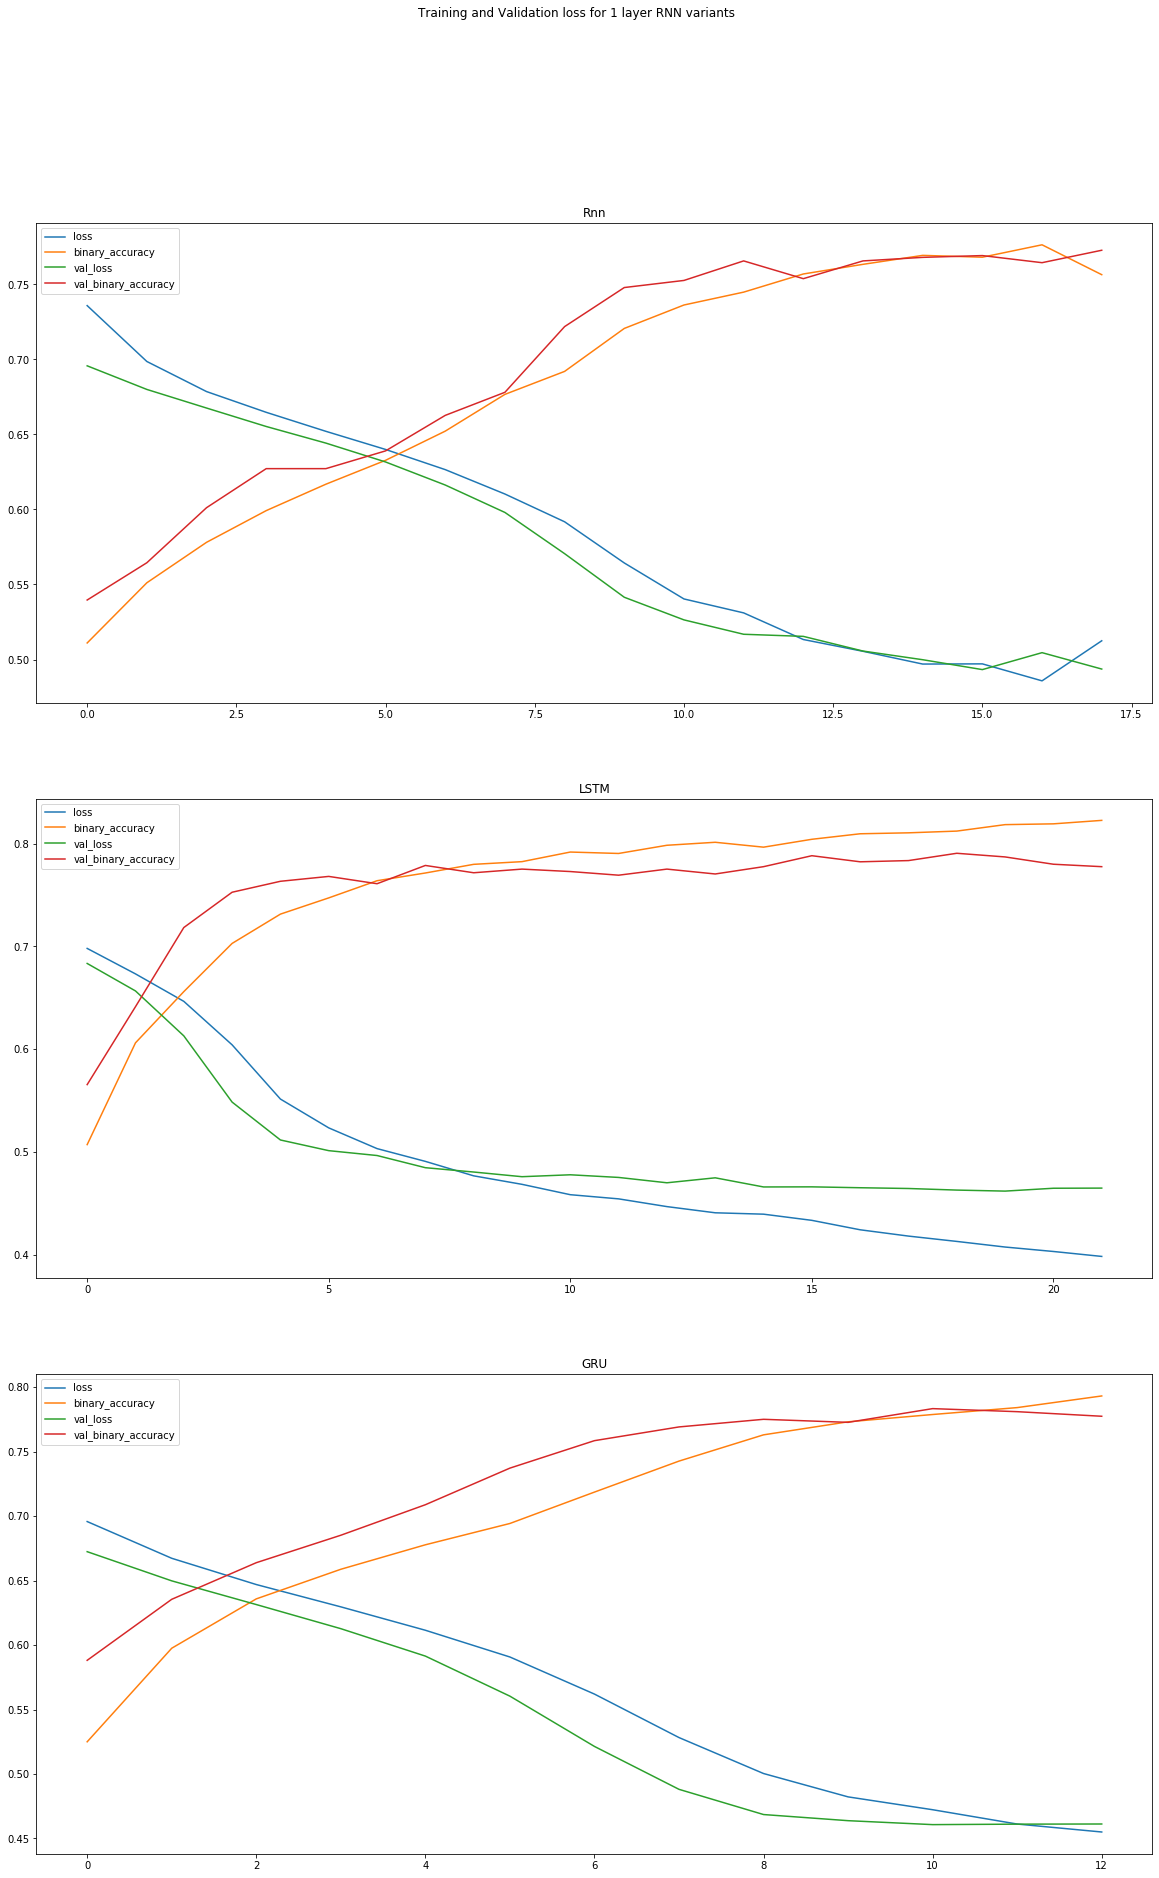

In [119]:
def plot_history(histories, title = None, sub_titles = None, width = 2, plot_metrics = None):
    if plot_metrics is not None:
        plot_metrics += ['val_' + m for m in plot_metrics]
    else:
        plot_metrics = list(histories[0].history.keys())
    histories = [h.history for h in histories]
    n_plots = len(histories)
    options = {'figsize': [20,30]}
    fig, ax = plt.subplots(n_plots, **options)
    if title is not None:
        fig.suptitle(title)
    for i in range(n_plots):
        history = histories[i]
        for key in plot_metrics:
            vals = history[key]
            ax[i].plot(range(len(vals)), vals, label=key)
            if sub_titles is not None:
                ax[i].set_title(sub_titles[i])
        if len(history.keys()) > 1:
            ax[i].legend()
plot_history(vanilla_hists,
             title = 'Training and Validation loss for 1 layer RNN variants', 
             sub_titles = ['Rnn','LSTM','GRU'])

In [120]:
def best_timestep(history, metric_name = 'val_binary_accuracy', big_good = True):
    values = history.history[metric_name]
    evals = [np.mean( values[np.max([i-1,0]): np.min([i+1,len(values)-1])] ) for i in range(len(values))]
    if not big_good:
        evals = [-i for i in evals]
    best_itter = np.argmax(evals)
    best_val = values[best_itter]
    result = {key: value[best_itter] for key, value in history.history.items() if re.search('val_', key) is not None}
    result['itter'] = best_itter
    return result
[best_timestep(hist) for hist in vanilla_hists]

[{'val_loss': 0.4932674384681431,
  'val_binary_accuracy': 0.7692308,
  'itter': 15},
 {'val_loss': 0.46215808902971844,
  'val_binary_accuracy': 0.78698224,
  'itter': 19},
 {'val_loss': 0.46107545512667775,
  'val_binary_accuracy': 0.7810651,
  'itter': 11}]

In [121]:
#I don't want to run a million experiments so I'll stick to the GRU model
best_model = LstmModel
best_epochs = 20
run_args = {'model_type': best_model,
           'epochs': best_epochs,
           'verbose': 0}

In [122]:
def get_best_results(history_list, configs):
    best_result_list = [best_timestep(hist) for hist in history_list]
    best_config = configs[ np.argmax([n['val_binary_accuracy'] for n in best_result_list]) ]
    print([n['val_binary_accuracy'] for n in best_result_list])
    return best_config

def lineplot_small_multiples(histories, title = None, sub_title_func = None, width = 2):
    histories = [h.history for h in histories]
    n_plots = len(histories)
    n_rows = int(np.ceil(n_plots/width))
    options = {'figsize': [40/n_rows,30/width]}
    fig, ax = plt.subplots(n_rows, width, **options)
    if title is not None:
        fig.suptitle(title)
    for i in range(n_rows*width):
        x = int(i%width)
        y = int(np.floor(i/width))
        if n_rows > 1 and width > 1:
            axis = ax[y,x]
        elif width > 1:
            axis = ax[x]
        else:
            axis = ax[y]
        if i < n_plots:
            history = histories[i]
            for key, vals in history.items():
                axis.plot(range(len(vals)), vals, label=key)
                if sub_title_func is not None:
                    axis.set_title(sub_title_func(i))
            if len(history.keys()) > 1:
                axis.legend()
        else:
            fig.delaxes(axis)

In [123]:
seq_len_hists = []
seq_options = [12, 25, 36, 50]
for seq_len in seq_options:
    history = run_model(**run_args)
    seq_len_hists.append(history)
best_seq_len = get_best_results(seq_len_hists, seq_options)
run_args['sequence_len'] = best_seq_len

[0.7857988, 0.77988166, 0.77633137, 0.7786982]


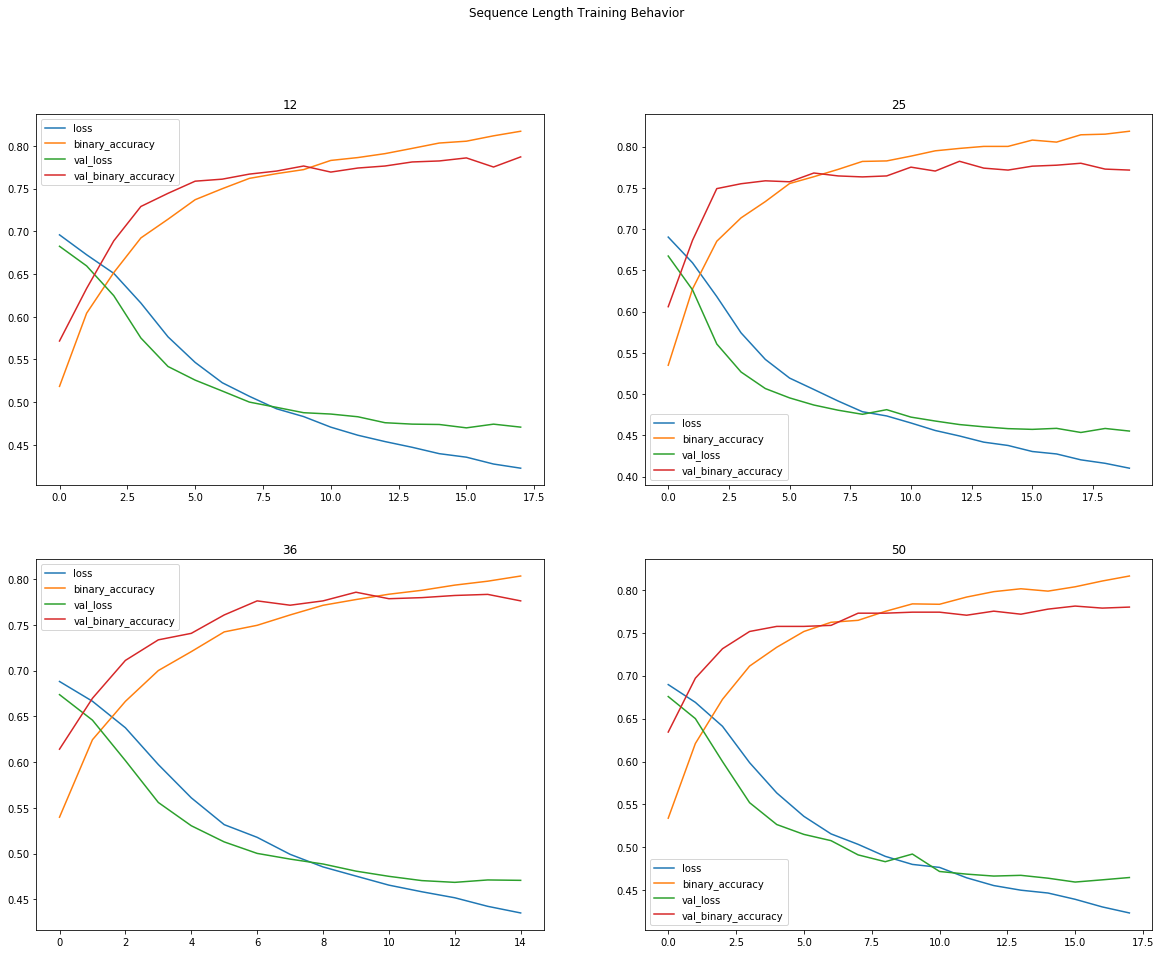

In [124]:
lineplot_small_multiples(seq_len_hists, title = 'Sequence Length Training Behavior', sub_title_func = lambda x: str(seq_options[x]))

In [125]:
layer_hists = []
layer_configs = [[4], [8], [16], [32]]
for layer_config in layer_configs:
    model_args = {'hidden_states': layer_config}
    history = run_model(model_args = model_args, **run_args)
    layer_hists.append(history)
best_layer_config = get_best_results(layer_hists, layer_configs)
model_args = {'hidden_states': best_layer_config}

[0.75384617, 0.7668639, 0.7668639, 0.7621302]


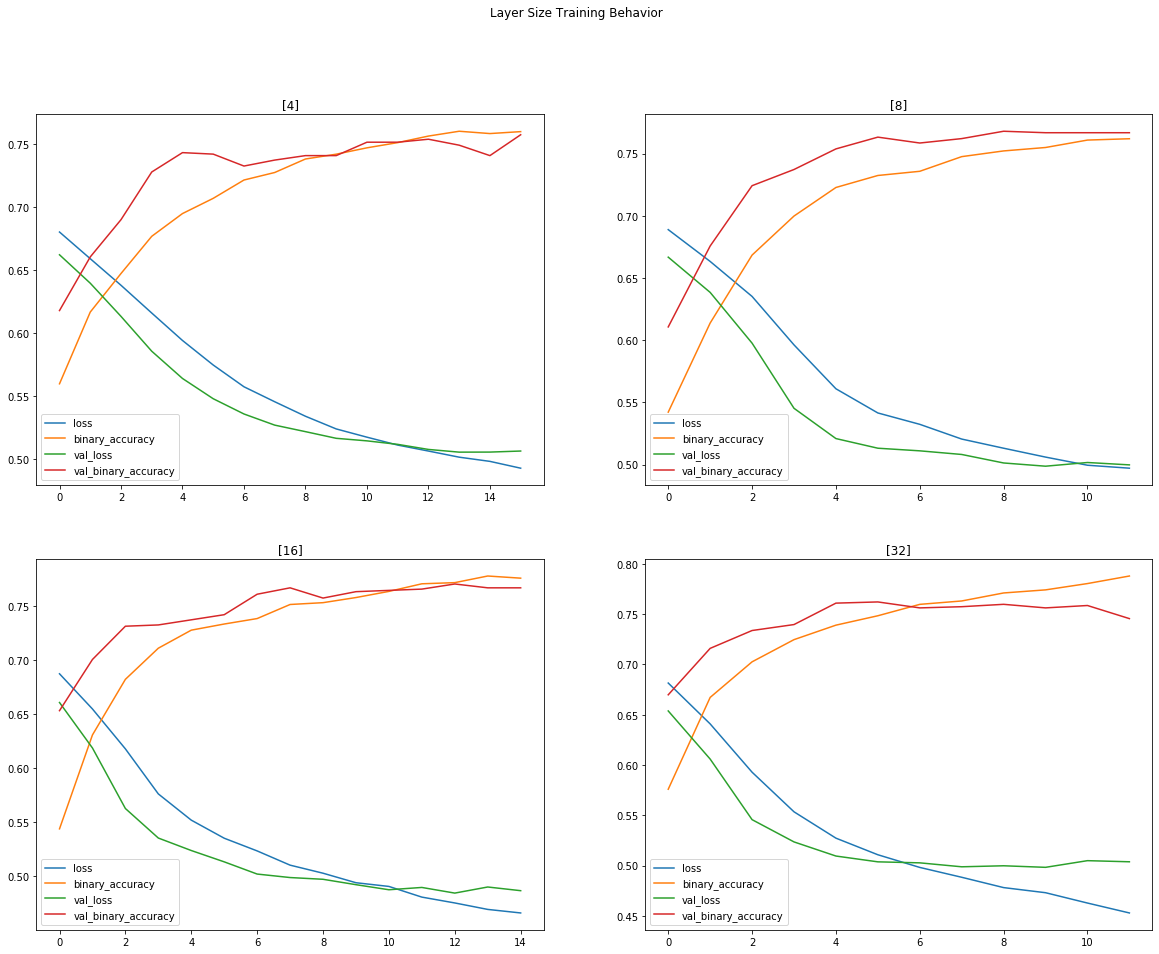

In [126]:
lineplot_small_multiples(layer_hists, title = 'Layer Size Training Behavior', 
                         sub_title_func = lambda x: str(layer_configs[x]))

In [127]:
glove_layer_sizes = [50, 100, 300]
glove_hists = []
for glove_size in glove_layer_sizes:
    model_args['embedding'] = glove_size
    history = run_model(model_args = model_args, **run_args)
    glove_hists.append(history)
best_glove_size = get_best_results(glove_hists, glove_layer_sizes)
model_args['embedding'] = best_glove_size

[0.7301775, 0.7289941, 0.7467456]


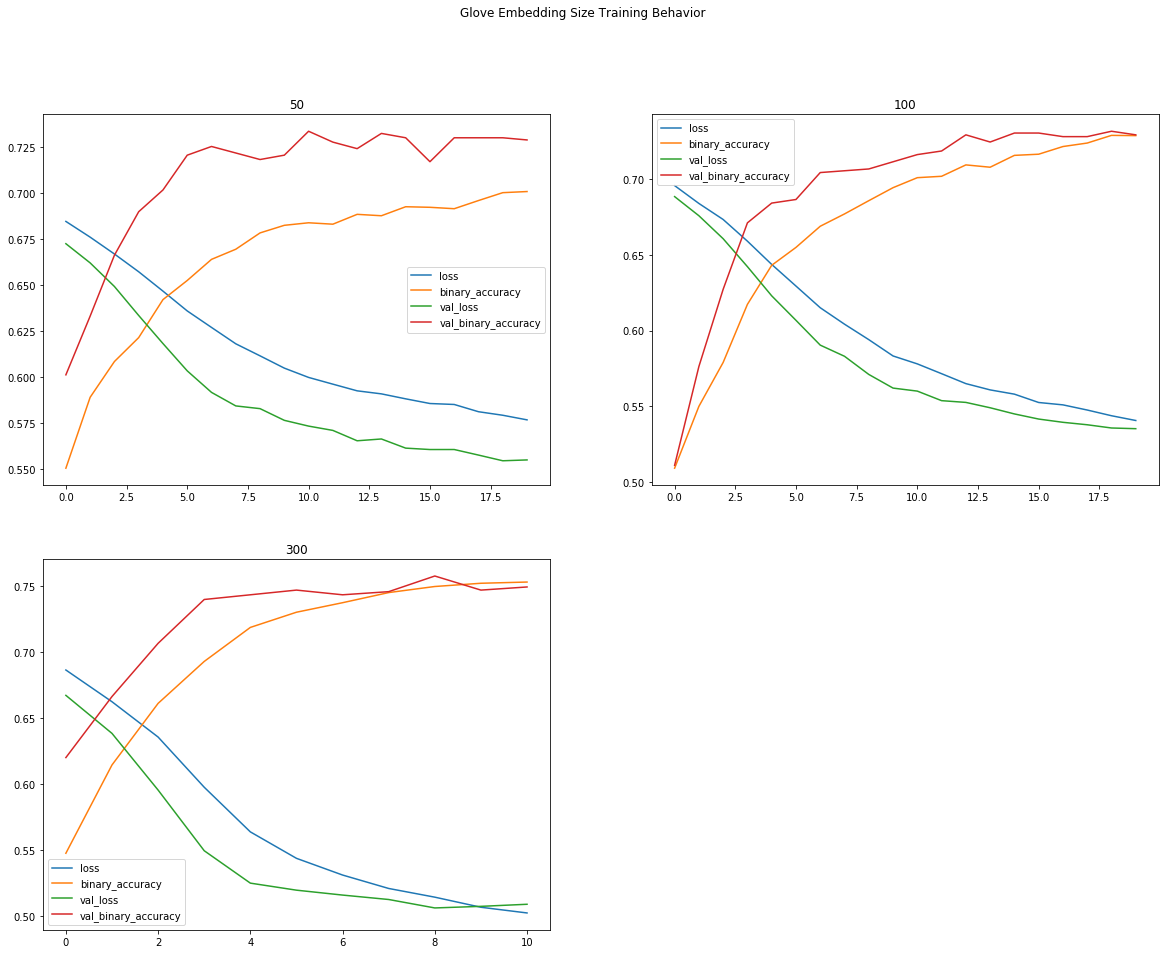

In [128]:
lineplot_small_multiples(glove_hists, title = 'Glove Embedding Size Training Behavior',
                        sub_title_func = lambda x: str(glove_layer_sizes[x]))

In [129]:
train_glove_configs = [True, False]
train_glove_hist = []
for train_glove in train_glove_configs:
    model_args['train_embeddings'] = train_glove
    history = run_model(model_args = model_args, **run_args)
    train_glove_hist.append(history)
should_we_train_glove = get_best_results(train_glove_hist, train_glove_configs)
model_args['train_embeddings'] = should_we_train_glove

[0.7502959, 0.7585799]


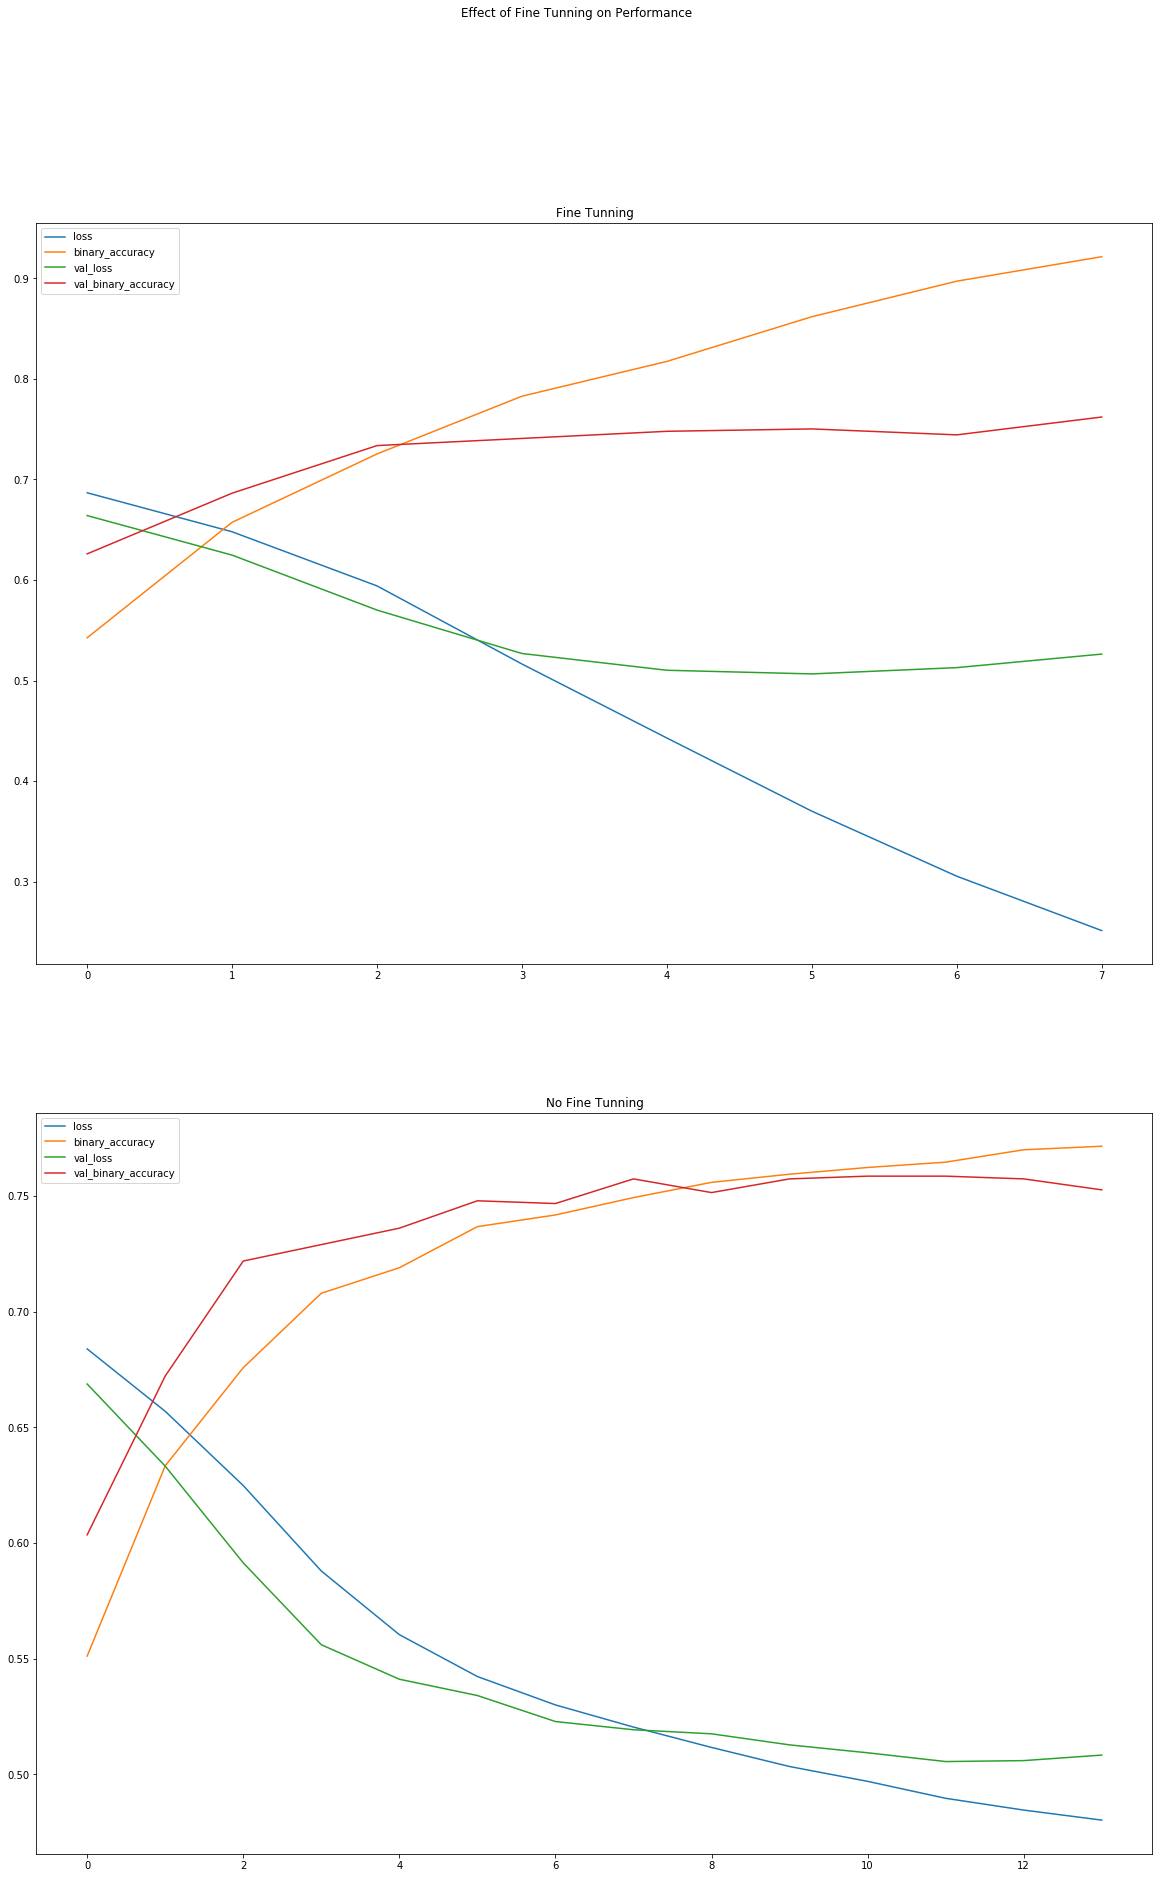

In [130]:
lineplot_small_multiples(train_glove_hist, width = 1,
                         title = 'Effect of Fine Tunning on Performance',
                         sub_title_func = lambda x: 'Fine Tunning' if x == 0 else 'No Fine Tunning')

In [131]:
print(model_args)
print(run_args)

{'hidden_states': [8], 'embedding': 300, 'train_embeddings': False}
{'model_type': <class '__main__.LstmModel'>, 'epochs': 20, 'verbose': 0, 'sequence_len': 12}


In [156]:
def find_best_model(model_type, seq_len = 12, epochs = 20):
    xtrain, ytrain = get_dataset('train', seq_len)
    xval, yval = get_dataset('val', seq_len)
    best_score = 0
    best_model = None
    es_callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', 
                                patience=2, 
                                restore_best_weights = True)
    for embedding in [50,100,300]:
        for hidden_states in [[8], [16], [32], [64]]:    
            for train_embeddings in [True, False]:
                model_args = {'hidden_states': hidden_states,
                             'embedding': embedding,
                             'train_embeddings': train_embeddings}
                model = compile_model(model_type, .005, model_args, 
                                      ['BinaryAccuracy','Precision','Recall'])
                hist = model.fit(xtrain, ytrain,
                          validation_data = (xval, yval),
                          callbacks = [es_callback],
                          batch_size = 500,
                          epochs = epochs,
                          verbose = 0)
                score = np.max(hist.history['val_binary_accuracy'])
                if score > best_score:
                    best_score = score
                    best_model = model
                    print(score)
    return model

def evaluate_best_model(model_type):
    model = find_best_model(model_type)
    xtest, ytest = get_dataset('test', 12)
    [eval_loss, eval_acc, eval_precision, eval_recall] = model.evaluate(xtest, ytest)
    f1_score = 2*eval_precision*eval_recall/(eval_precision + eval_recall)
    result = {'precision': eval_precision, 'recall': eval_recall, 'f1_score': f1_score}
    return {model.__class__.__name__: result}

In [ ]:
model_test_results = [evaluate_best_model(m) for m in [RnnModel, LstmModel, GruModel]]

In [149]:
pd.D

'type'

In [46]:
#things to try for
glove_sizes = [300]
seq_lens = [12, 25, 50]
learning_rates = [.01] 50
layer_configs = [[4], [4,4], [16], [8], [8,8], [16,16]]
model_types = [LstmModel, GruModel]
train_glove_settings = [True, False]
results = []
for glove_size in glove_sizes:
    for model_type in model_types:
        for layer_config in layer_configs:
            for seq_len in seq_lens:
                for train_glove in train_glove_settings:
                    for lr in learning_rates:
                        result_dict = {'glove_size': glove_size,
                                      'model': str(model_type),
                                      'layers': layer_config,
                                      'sequence_length': seq_len,
                                      'learning_rate': lr}
                        model_args = {'embedding': glove_size,
                                       'hidden_states': layer_config,
                                       'train_embeddings': train_glove }
                        history = run_model(model_type,
                                           sequence_len = seq_len,
                                           learning_rate = lr,
                                           epochs = 30,
                                           model_args = model_args,
                                           verbose = 0)
                        best = best_timestep(history)
                        for key, val in best.items():
                            result_dict[key] = val
                        result_dict['history'] = history
                        results.append(result_dict)
            
                        print(result_dict)
                        print()

398  words from dataset not in glove
{'glove_size': 300, 'model': "<class '__main__.LstmModel'>", 'layers': [4], 'sequence_length': 12, 'learning_rate': 0.01, 'val_loss': 0.5990063678583449, 'val_binary_accuracy': 0.7337278, 'itter': 2, 'history': <tensorflow.python.keras.callbacks.History object at 0x7f90692f0cf8>}

398  words from dataset not in glove
{'glove_size': 300, 'model': "<class '__main__.LstmModel'>", 'layers': [4], 'sequence_length': 12, 'learning_rate': 0.01, 'val_loss': 0.5163151092783234, 'val_binary_accuracy': 0.747929, 'itter': 4, 'history': <tensorflow.python.keras.callbacks.History object at 0x7f9068442e10>}

398  words from dataset not in glove
{'glove_size': 300, 'model': "<class '__main__.LstmModel'>", 'layers': [4], 'sequence_length': 25, 'learning_rate': 0.01, 'val_loss': 0.5767598374355474, 'val_binary_accuracy': 0.7715976, 'itter': 2, 'history': <tensorflow.python.keras.callbacks.History object at 0x7f905352e6a0>}

398  words from dataset not in glove
{'glove

KeyboardInterrupt: 

In [ ]:
values = [r['val_binary_accuracy']]